目的：各種予防接種健康被害審査の審議結果をデータベース化するための試み<br/>
基本的な流れは、<br/>
- 対象PDFを読み込み、ページごとに罫線位置を把握して必要箇所の矩形を把握
- 矩形アドレスをtabulaで指定して読み込み、DataFrame化
- これを現在公開されている記録ごとに行う

In [1]:
#必要モジュールインストール、インポート

#pdf2imageではpillow9.2.0だとエラーを吐くため9.0.0で動かす
!pip install Pillow==9.0.0
from PIL import Image

#PDFを画像変換するためのパッケージのインストールなど
!pip install pdf2image
!apt-get update
!apt-get install poppler-utils
import os
from pathlib import Path
from pdf2image import convert_from_path

!pip install pyocr
import pyocr
import pyocr.builders
import glob
import pprint
import sys

# 各種処理設定インポート
# pandas というモジュールを読み込み、以下では pd と書きます。
#numexpr 2.8.5にエラー、２．８．４にダウングレードして使用する
!pip install numexpr==2.8.4
import pandas as pd

# math(数学的処理用モジュール)をインポート
import math

# HTTP通信を簡便に読み込むライブラリをインポート
import requests

# 正規表現による文字の処理
import re

#待機処理用
import time

#pdfminer.sixインストール
!pip install pdfminer.six

import urllib.request

!pip install tabula-py
import tabula



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,074 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,517 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://cloud.r-project.org/bin/linux/ubuntu jammy-c

In [2]:
#PyOCR使用可能確認
#参考：https://qiita.com/m-hayashi/items/e2acc640fb436d09f128
#参考２（tessdataの日本語最適化）：https://qiita.com/santarou6/items/0af025c05c765a8753bc

#Tesseract OCRの関連ライブラリーとPythonラッパーをインストール
#!apt install tesseract-ocr
!apt install tesseract-ocr libtesseract-dev tesseract-ocr-jpn
!apt install libtesseract-dev

#日本語トレーニングデータのダウンロードとインストール
#!curl -L https://github.com/tesseract-ocr/tessdata/raw/master/jpn.traineddata > jpn.traineddata
!curl -L https://github.com/tesseract-ocr/tessdata_fast/blob/master/jpn.traineddata > jpn.traineddata
!cp jpn.traineddata /usr/share/tesseract-ocr/tessdata

#OCRが使用可能かをチェック
tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("OCR tool is not found")
    sys.exit(1)

#OCRツール名を表示
tool = tools[0]
print("OCR tool is '%s'" % (tool.get_name()))
#OCR対応言語を表示
langs = tool.get_available_languages()
print("Available languages: %s" % ", ".join(langs))
lang = langs[0]
print("Will use lang '%s'" % (lang))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-jpn tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,950 kB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:5 ht

In [3]:
#pdfに直接線を書き込み、そのpdfを読み込むことで適切なテーブルになるようにする
#参考：　https://daeudaeu.com/python_pdf/
!pip install pdfrw
!pip install reportlab

from pdfrw import PdfReader
from pdfrw.buildxobj import pagexobj
from pdfrw.toreportlab import makerl
from reportlab.pdfgen import canvas
from reportlab.pdfbase.cidfonts import UnicodeCIDFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.units import mm

#横向きで作成するため
#参考：　https://www.school.ctc-g.co.jp/columns/hishinuma/hishinuma37.html
from reportlab.lib.pagesizes import B2,A2,B3,A3,A4,landscape



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.9 MB/s eta 0:00:00


In [19]:
import numpy as np

#疾病障害認定審査会のまとめページは以下
#　https://www.mhlw.go.jp/stf/shingi/shingi-shippei_127696_00001.html

address_dict = {

                "20210819":"https://www.mhlw.go.jp/content/10900000/000821004.pdf",
                "20210913":"https://www.mhlw.go.jp/content/10900000/000831880.pdf",
                "20211022":"https://www.mhlw.go.jp/content/10900000/000846886.pdf",
                "20211119":"https://www.mhlw.go.jp/content/10900000/000857105.pdf",
                "20211209":"https://www.mhlw.go.jp/content/10900000/000864789.pdf",
                "20211223":"https://www.mhlw.go.jp/content/10900000/000872304.pdf",
                "20220128":"https://www.mhlw.go.jp/content/10900000/000888942.pdf",
                "20220210":"https://www.mhlw.go.jp/content/10900000/000896495.pdf",
                "20220224":"https://www.mhlw.go.jp/content/10900000/000901780.pdf",
                "20220325":"https://www.mhlw.go.jp/content/10900000/000919087.pdf",
                "20220418":"https://www.mhlw.go.jp/content/10900000/000930467.pdf",
                "20220428":"https://www.mhlw.go.jp/content/10900000/000935356.pdf",
                "20220519":"https://www.mhlw.go.jp/content/10900000/000952254.pdf",
                "20220602":"https://www.mhlw.go.jp/content/10900000/000946675.pdf",
                "20220623":"https://www.mhlw.go.jp/content/10900000/000955760.pdf",
                "20220725":"https://www.mhlw.go.jp/content/10900000/000968535.pdf",
                "20220728":"https://www.mhlw.go.jp/content/10900000/000970743.pdf",
                "20220909":"https://www.mhlw.go.jp/content/10900000/000988225.pdf",
                "20220922":"https://www.mhlw.go.jp/content/10900000/001003154.pdf",
                "20221017":"https://www.mhlw.go.jp/content/10900000/001002016.pdf",
                "20221027":"https://www.mhlw.go.jp/content/10900000/001038819.pdf",
                "20221107":"https://www.mhlw.go.jp/content/10900000/001038825.pdf",
                "20221124":"https://www.mhlw.go.jp/content/10900000/001041126.pdf",
                "20221212":"https://www.mhlw.go.jp/content/10900000/001038829.pdf",
                "20221222":"https://www.mhlw.go.jp/content/10900000/001028806.pdf",
                "20230112":"https://www.mhlw.go.jp/content/10900000/001036860.pdf",
                "20230113":"https://www.mhlw.go.jp/content/10900000/001037256.pdf",
                "20230123":"https://www.mhlw.go.jp/content/10900000/001094615.pdf",
                "20230206":"https://www.mhlw.go.jp/content/10900000/001052852.pdf",
                "20230209":"https://www.mhlw.go.jp/content/10900000/001094616.pdf",
                "20230210":"https://www.mhlw.go.jp/content/10900000/001056934.pdf",
                "20230314":"https://www.mhlw.go.jp/content/10900000/001072628.pdf",
                "20230317":"https://www.mhlw.go.jp/content/10900000/001094617.pdf",
                "20230327":"https://www.mhlw.go.jp/content/10900000/001094619.pdf",
                "20230407":"https://www.mhlw.go.jp/content/10900000/001094624.pdf",
                "20230417":"https://www.mhlw.go.jp/content/10900000/001094629.pdf",
                "20230420":"https://www.mhlw.go.jp/content/10900000/001120061.pdf",
                "20230508":"https://www.mhlw.go.jp/content/10900000/001094635.pdf",
                "20230526":"https://www.mhlw.go.jp/content/10900000/001110926.pdf",
                "20230531":"https://www.mhlw.go.jp/content/10900000/001102618.pdf",
                "20230609":"https://www.mhlw.go.jp/content/10900000/001105758.pdf",
                "20230619":"https://www.mhlw.go.jp/content/10900000/001109493.pdf",
                "20230626":"https://www.mhlw.go.jp/content/10900000/001113128.pdf",
                "20230629":"https://www.mhlw.go.jp/content/10900000/001115365.pdf",
                "20230710":"https://www.mhlw.go.jp/content/10900000/001119635.pdf",
                "20230714":"https://www.mhlw.go.jp/content/10900000/001121511.pdf",
                "20230726":"https://www.mhlw.go.jp/content/10900000/001126416.pdf",
                "20230731":"https://www.mhlw.go.jp/content/10900000/001128563.pdf",
                "20230804":"https://www.mhlw.go.jp/content/10900000/001131819.pdf",
                "20230821":"https://www.mhlw.go.jp/content/10900000/001136789.pdf",
                "20230830":"https://www.mhlw.go.jp/content/10900000/001140613.pdf",
                "20230831":"https://www.mhlw.go.jp/content/10900000/001140990.pdf",
                "20230911":"https://www.mhlw.go.jp/content/10900000/001145159.pdf",
                "20230915":"https://www.mhlw.go.jp/content/10900000/001147110.pdf",
                "20230922":"https://www.mhlw.go.jp/content/10900000/001149268.pdf",
                "20230927":"https://www.mhlw.go.jp/content/10900000/001150876.pdf",
                "20231006":"https://www.mhlw.go.jp/content/10900000/001154688.pdf",
                "20231016":"https://www.mhlw.go.jp/content/10900000/001157241.pdf",
                "20231023":"https://www.mhlw.go.jp/content/10900000/001159848.pdf",
                "20231026":"https://www.mhlw.go.jp/content/10900000/001161637.pdf",
                "20231113":"https://www.mhlw.go.jp/content/10900000/001166881.pdf",
                "20231117":"https://www.mhlw.go.jp/content/10900000/001169037.pdf",
                "20231124":"https://www.mhlw.go.jp/content/10900000/001171205.pdf",
                "20231129":"https://www.mhlw.go.jp/content/10900000/001173075.pdf",
                "20231208":"https://www.mhlw.go.jp/content/10900000/001177107.pdf",
                "20231218":"https://www.mhlw.go.jp/content/10900000/001179956.pdf",
                "20231225":"https://www.mhlw.go.jp/content/10900000/001183565.pdf",
                "20231227":"https://www.mhlw.go.jp/content/10900000/001185105.pdf",
                "20240115":"https://www.mhlw.go.jp/content/10900000/001190696.pdf",
                "20240119":"https://www.mhlw.go.jp/content/10900000/001194447.pdf",
                "20240126":"https://www.mhlw.go.jp/content/10900000/001198698.pdf",
                "20240131":"https://www.mhlw.go.jp/content/10900000/001201570.pdf",
                "20240209":"https://www.mhlw.go.jp/content/10900000/001208226.pdf",
                "20240219":"https://www.mhlw.go.jp/content/10900000/001212315.pdf",
                "20240226":"https://www.mhlw.go.jp/content/10900000/001214935.pdf",
                "20240229":"https://www.mhlw.go.jp/content/10900000/001217025.pdf"
                }
#[①②③④⑤⑥⑦⑧]
#['性別'①'接種時年齢'②'ワクチン'③'請求内容'④'疾病又は障害名'⑤'関連する基礎疾患及び既往症'⑥'判定'⑦'否認理由'⑧'備考']
#用紙サイズが変わっていることがあることから、その際には補正を行う、基本はA4
#たまに用紙サイズに合わないようなものもあるため随時手直しする
#用紙サイズ変更倍率
#A2=A4*2.0
#A3=A4*1.41
#B2=A4*2.452
#B3=A4*1.73
youshi_dict = {A4:1.0,
               A3:1.41,
               A2:2.0,
               B3:1.73,
               B2:2.452}

hline_dict = {

              "20210819":[A4,np.array([65,76,101,200,215,238])],
              "20210913":[A2,np.array([62,71.5,91,180,195,212])],
              "20211022":[A4,np.array([69,78.5,102,197,212,235])],
              "20211119":[A4,np.array([69,78.5,102,197,212,235])],
              "20211209":[B2,np.array([79,86,101,175,187,202])],
              "20211223":[A2,np.array([62,71.5,91,180,195,212])],
              "20220128":[A2,np.array([62,71.5,91,180,195,212])],
              "20220210":[A2,np.array([77,86,108,197,212,230])],
              "20220224":[A2,np.array([62,71.5,91,180,195,212])],
              "20220325":[A3,np.array([37,51,83,211,228,252])],
              "20220418":[A4,[36,53,79,108,181,230,244,258]],
              "20220428":[B3,np.array([35,52,76,103,172,220,232,245])],
              "20220519":[A4,[36,53,79,108,181,230,244,258]],
              "20220602":[A4,[36,53,79,108,181,230,244,258]],
              "20220623":[A4,[42,56,81,110,182,227,241,254]],
              "20220725":[A4,[36,53,79,108,181,230,244,258]],
              "20220728":[A4,[42,56,81,110,182,227,241,254]],
              "20220909":[A4,[36,53,79,108,182,230,244,258]],
              "20220922":[A4,[40,57,80,110,182,227,240,253]],
              "20221017":[A4,[35,52,76,103,176,225,237,250]],
              "20221027":[A4,[35,49,72,99,182,227,239,251]],
              "20221107":[A4,[37,55,83,174,224,235,247]],#新型コロナ死亡事例等のみのため項目が少なくなっている
              "20221124":[A4,[35,49,72,99,182,227,239,251]],
              "20221212":[A4,[37,52,80,107,180,229,242,254]],
              "20221222":[A4,[35,49,72,99,181,227,239,251]],
              "20230112":[A4,[40,56,80,109,176,226,239,251]],
              "20230113":[A4,[35,49,72,99,181,227,239,251]],
              "20230123":[A4,[35,49,72,99,181,227,239,251]],
              "20230206":[A4,[35,49,72,99,181,227,239,251]],
              "20230209":[A4,[35,49,72,100,178,227,239,251]],
              "20230210":[A4,[40,57,83,109,178,227,239,251]],
              "20230314":[A4,[36,52,79,107,180,232,241,258]],
              "20230317":[A4,[36,52,73,100,172,227,238,253]],
              "20230327":[A4,[34,50,73,105,175,227,238,253]],
              "20230407":[A4,[32,45,66,91,167,216,229,245]],
              "20230417":[A4,[36,50,77,105,176,225,237,249]],
              "20230420":[A4,[32,45,65,91,170,220,234,247]],
              "20230508":[A4,[32,45,65,91,170,220,234,247]],
              "20230526":[A4,[32,47,72,102,170,225,238,255]],
              "20230531":[A4,[33,49,70,97,164,212,231,245]],
              "20230609":[A4,[35,47,68,95,163,215,226,242]],
              "20230619":[A4,[35,50,71,99,173,230,240,255]],
              "20230626":[A4,[35,50,68,98,165,235,248,263]],
              "20230629":[A4,[35,54,76,105,181,235,250,271]],
              "20230710":[A4,[35,50,72,99,181,235,247,271]],
              "20230714":[A4,[32,47,72,99,173,225,241,255]],
              "20230726":[A4,[34,52,73,102,178,233,245,267]],
              "20230731":[B3,np.array([30,45,63,88.5,150,200.5,213,228])],
              "20230804":[A4,np.array([34,52,73,102,178,233,245,267])],
              "20230821":[A4,np.array([34,50,72,99,173,228,240,260])],
              "20230830":[B3,np.array([30,45,63,88.5,150,200.5,213,228])],
              "20230831":[A4,np.array([34,50,72,99,170,224,237,255])],
              "20230911":[A4,np.array([34,52,72,102,174,228,243,263])],
              "20230915":[A2,np.array([32,46,67.5,91.5,155,205,217,228])],
              "20230922":[B3,np.array([30,43,63,92.5,158,217,226,238])],
              "20230927":[A3,np.array([35,55,75,106,183,243,258,275])],
              "20231006":[A4,np.array([34,52,72,102,177,231,246,266])],
              "20231016":[A2,np.array([32,46,67.5,91.5,155,205,217,228])],
              "20231023":[A3,np.array([35,55,75,107,176,235,252,270])],
              "20231026":[A3,np.array([35,53,75,104,181,239,254,273])],
              "20231113":[A4,np.array([34,52,72,99,179,231,246,266])],
              "20231117":[A4,np.array([34,49,69,95,172,231,242,254])],
              "20231124":[A3,np.array([35,53,75,107,177,237,251,270])],
              "20231129":[A4,np.array([35,53,75,105,179,237,251,270])],
              "20231208":[A4,np.array([35,53,75,103,178,235,249,267])],
              "20231218":[A2,np.array([32,48,67.5,93,164,221,230,243])],
              "20231225":[A3,np.array([35,53,75,107,183,240,254,273])],
              "20231227":[A4,np.array([34,52,72,102,174,228,243,263])],
              "20240115":[A4,np.array([34,53,72,102,177,232,247,266])],
              "20240119":[B3,np.array([36,52,77,104,166,230,241,256])],
              #"変更前20240126":[A3,np.array([35,54,75,107,177,240,256,275])],
              "20240126":[A3,np.array([35,54,75,107,177,240,256,275])],
              "20240131":[A3,np.array([35,54,75,107,184,240,256,275])],
              "20240209":[A4,np.array([35,54,75,104,177,235,246,266])],
              "20240219":[B3,np.array([36,52,77,104,166,230,241,256])],
              "20240226":[A3,np.array([35,54,75,107,183,240,256,275])],
              "20240229":[A4,np.array([35,54,75,104,180,238,249,269])]
              }



      x1   y1    x2    y2   distX   distY
0    158  489   418   489   260.0     0.0
1    158  492   417   492   259.0     0.0
2    159  530  2274   530  2115.0     0.0
3    159  532  2274   532  2115.0     0.0
4    159  610  2274   610  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
56  1603  579  1811   579   208.0     0.0
57  1872    0  1872  1573     0.0  1573.0
58  1958    0  1958  1573     0.0  1573.0
59  1961  399  1961  1574     0.0  1175.0
60  2116    0  2116  1573     0.0  1573.0

[61 rows x 6 columns]
[159, 2274]
[530, 1572]


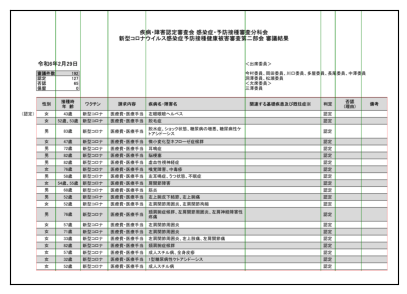

      x1   y1    x2    y2   distX   distY
0    159  357  2274   357  2115.0     0.0
1    159  359  2274   359  2115.0     0.0
2    159  442  2274   442  2115.0     0.0
3    159  482  2274   482  2115.0     0.0
4    159  484  2274   484  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
72  1418    0  1418  1574     0.0  1574.0
73  1872    0  1872  1573     0.0  1573.0
74  1958    0  1958  1573     0.0  1573.0
75  1961    0  1961  1574     0.0  1574.0
76  2116    0  2116  1573     0.0  1573.0

[77 rows x 6 columns]
[159, 2274]
[70, 1570]


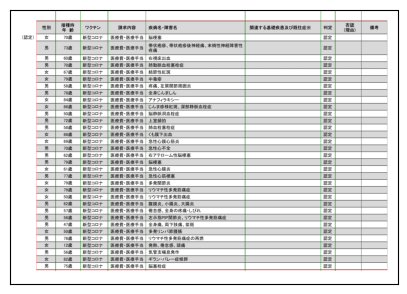

      x1   y1    x2    y2   distX   distY
0    159  232  2274   232  2115.0     0.0
1    159  234  2274   234  2115.0     0.0
2    159  317  2274   317  2115.0     0.0
3    159  442  2274   442  2115.0     0.0
4    159  482  2274   482  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
70  1418    0  1418  1574     0.0  1574.0
71  1872    0  1872  1573     0.0  1573.0
72  1958    0  1958  1573     0.0  1573.0
73  1961    0  1961  1574     0.0  1574.0
74  2116    0  2116  1573     0.0  1573.0

[75 rows x 6 columns]
[159, 2274]
[70, 1570]


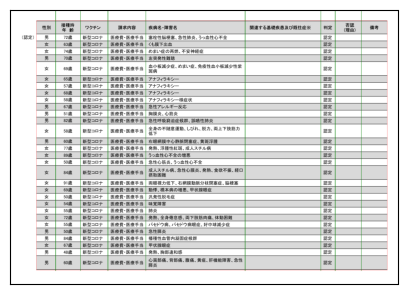

      x1   y1    x2    y2   distX   distY
0    159   72  2274    72  2115.0     0.0
1    159  232  2274   232  2115.0     0.0
2    159  234  2274   234  2115.0     0.0
3    159  357  2274   357  2115.0     0.0
4    159  359  2274   359  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
63  1418    0  1418  1574     0.0  1574.0
64  1872    0  1872  1573     0.0  1573.0
65  1958    0  1958  1573     0.0  1573.0
66  1961    0  1961  1574     0.0  1574.0
67  2116    0  2116  1573     0.0  1573.0

[68 rows x 6 columns]
[159, 2274]
[70, 1570]


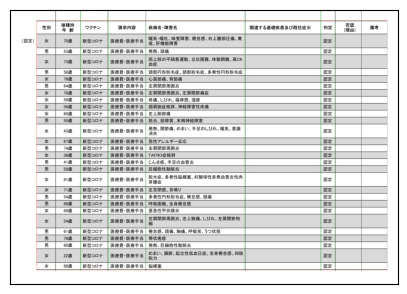

      x1   y1    x2    y2   distX   distY
0    159  357  2274   357  2115.0     0.0
1    159  359  2274   359  2115.0     0.0
2    159  442  2274   442  2115.0     0.0
3    159  482  2274   482  2115.0     0.0
4    159  484  2274   484  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
72  1418    0  1418  1574     0.0  1574.0
73  1872    0  1872  1573     0.0  1573.0
74  1958    0  1958  1573     0.0  1573.0
75  1961    0  1961  1574     0.0  1574.0
76  2116    0  2116  1573     0.0  1573.0

[77 rows x 6 columns]
[159, 2274]
[70, 1570]


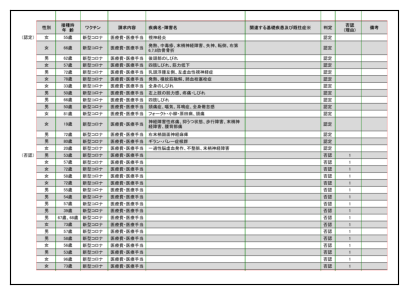

      x1   y1    x2    y2   distX   distY
0    159   72  2274    72  2115.0     0.0
1    159  192  2274   192  2115.0     0.0
2    159  232  2274   232  2115.0     0.0
3    159  234  2274   234  2115.0     0.0
4    159  357  2274   357  2115.0     0.0
..   ...  ...   ...   ...     ...     ...
70  1418    0  1418  1574     0.0  1574.0
71  1872    0  1872  1573     0.0  1573.0
72  1958    0  1958  1573     0.0  1573.0
73  1961    0  1961  1574     0.0  1574.0
74  2116    0  2116  1573     0.0  1573.0

[75 rows x 6 columns]
[159, 2274]
[70, 1570]


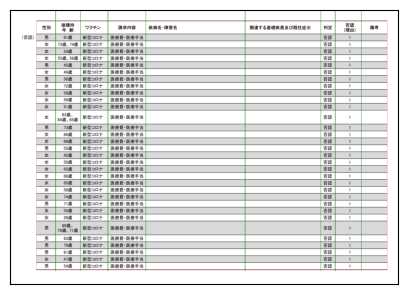

      x1    y1    x2    y2   distX   distY
0    159   232  2274   232  2115.0     0.0
1    159   234  2274   234  2115.0     0.0
2    159   317  2274   317  2115.0     0.0
3    159   357  2274   357  2115.0     0.0
4    159   359  2274   359  2115.0     0.0
..   ...   ...   ...   ...     ...     ...
64  1961   959  1961  1449     0.0   490.0
65  1991  1077  2254  1077   263.0     0.0
66  1991  1082  2205  1082   214.0     0.0
67  2027  1078  2255  1078   228.0     0.0
68  2116     0  2116  1074     0.0  1074.0

[69 rows x 6 columns]
[159, 2274]
[70, 820]


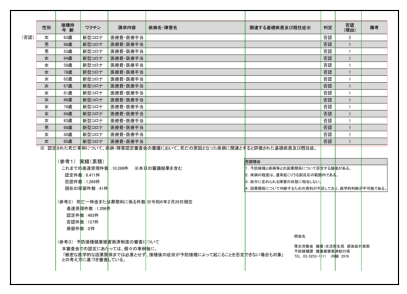

[{'page': 1, 'extraction_method': 'guess', 'x1': 59.10780669144982, 'x2': 845.3531598513011, 'y1': 197.0260223048327, 'y2': 584.3866171003717, 'width': 786.2453531598513, 'height': 387.360594795539}, {'page': 2, 'extraction_method': 'guess', 'x1': 59.10780669144982, 'x2': 845.3531598513011, 'y1': 26.022304832713754, 'y2': 583.64312267658, 'width': 786.2453531598513, 'height': 557.6208178438662}, {'page': 3, 'extraction_method': 'guess', 'x1': 59.10780669144982, 'x2': 845.3531598513011, 'y1': 26.022304832713754, 'y2': 583.64312267658, 'width': 786.2453531598513, 'height': 557.6208178438662}, {'page': 4, 'extraction_method': 'guess', 'x1': 59.10780669144982, 'x2': 845.3531598513011, 'y1': 26.022304832713754, 'y2': 583.64312267658, 'width': 786.2453531598513, 'height': 557.6208178438662}, {'page': 5, 'extraction_method': 'guess', 'x1': 59.10780669144982, 'x2': 845.3531598513011, 'y1': 26.022304832713754, 'y2': 583.64312267658, 'width': 786.2453531598513, 'height': 557.6208178438662}, {'pa

Mar 04, 2024 12:55:16 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:16 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:18 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:20 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:20 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:21 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:21 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:23 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:23 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:26 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 04, 2024 12:55:26 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Mar 04, 2024 12:55:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
M

   Unnamed: 0 接種時\r年 齢   ワクチン      請求内容                           疾病名・障害名  \
0           女      43歳  新型コロナ  医療費・医療手当                          左眼眼瞼ヘルペス   
1           女  52歳、53歳  新型コロナ  医療費・医療手当                               脱毛症   
2           男      83歳  新型コロナ  医療費・医療手当  脱水症、ショック状態、糖尿病の増悪、糖尿病性ケ\rトアシドーシス   
3           女      47歳  新型コロナ  医療費・医療手当                     微小変化型ネフローゼ症候群   
4           男      72歳  新型コロナ  医療費・医療手当                               耳鳴症   
5           男      82歳  新型コロナ  医療費・医療手当                               脳梗塞   
6           男      82歳  新型コロナ  医療費・医療手当                           虚血性視神経症   
7           女      76歳  新型コロナ  医療費・医療手当                          嗅覚障害、中毒疹   
8           男      58歳  新型コロナ  医療費・医療手当                     左耳鳴症、うつ状態、不眠症   
9           女  54歳、55歳  新型コロナ  医療費・医療手当                             肩関節障害   
10          男      68歳  新型コロナ  医療費・医療手当                                筋炎   
11          男      52歳  新型コロナ  医療費・医療手当                      左上腕皮下結節、左上腕痛   

In [20]:
#読み取り記録
rec_d = 20240229

#PDFを画像変換
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

#対象矩形の検出、1記録でページごとになるためちょっと時間がかかりそう
#pdf取り込み＞画像化＞直線検出＞矩形化＞アドレス記録

import shutil
import json

#各辞書を統合し、日付名を付けたjsonファイルとして管理する
record_date = str(rec_d)
rec_dir = "./" + record_date

#フォルダ有無の確認、なければ作成
def make_dir(dirpath):
    if not(os.path.exists(dirpath)):
        os.makedirs(dirpath)

#outputのファイルパス
img_path= rec_dir + "/image"
outimg_path = rec_dir + "/out_image"

make_dir(rec_dir)
make_dir(img_path)
make_dir(outimg_path)

url = address_dict[record_date]
r = requests.get(url,timeout=3).content
filename = rec_dir + "/data_{}.pdf".format(record_date)
with open(filename ,mode='wb') as f: # wb でバイト型を書き込める
  f.write(r)

# PDFファイルのパス
pdf_path = filename

#参考：https://qiita.com/shoku-pan/items/7a67f484a10430da6678
#参考2：https://note.com/dngri/n/nbbb83823e8f4
#参考3：https://teratail.com/questions/151317


in_path = filename
out_path = rec_dir + "/outdata_{}.pdf".format(record_date)


# PDFを読み込む
pdf = PdfReader(in_path, decompress=False)
# PDFのページデータを取得
#page = pdf.pages[1]

#出力用ページのサイズを原稿と同一サイズにする必要あり
youshi_size = hline_dict[record_date][0]
cc = canvas.Canvas(out_path, pagesize=landscape(youshi_size))

def page_add_hline(cnt,page):
    #pdfサイズ取得
    #MediaBoxはPdfArray型のため、ジェネレータとして取得する必要がある
    #原点は左下となるため注意
    #2.834で概ね等しい値になるあたりこっちかも>2.7でうまくいっている感
    #mediabox = [float(x)*2.834 for x in page.MediaBox]
    #print(mediabox)

    pp = pagexobj(page) #ページデータをXobjへの変換
    rl_obj = makerl(cc, pp) # ReportLabオブジェクトへの変換
    cc.doForm(rl_obj) # 展開

    cc.setLineWidth(0.3 * mm)
    cc.setStrokeColor("green")
    #.line(x1,y1,x2,y2)
    #line_xは各資料毎に異なるため、日付毎の辞書にしておく必要あり

    if youshi_size==A4:
      line_x = hline_dict[record_date][1]
      line_y = np.array([10,220])
    else:
      line_x = hline_dict[record_date][1] * youshi_dict[youshi_size]
      line_y = np.array([10,220]) * youshi_dict[youshi_size]

    #line_x = hline_dict[record_date][1]
    #line_y = np.array([10,220])*2.0

    [cc.line(x * mm, line_y[0] * mm, x * mm, line_y[1] * mm) for x in line_x]

    # ページデータの確定
    cc.showPage()

    return "page{:02d} add hline complete.".format(cnt+1)

#ページごとに線を付加する
list(map(page_add_hline, range(len(pdf.pages)), pdf.pages))

# PDFの保存
cc.save()

def make_image(num,page):

    file_name = "data_{:02d}.png".format(num)
    file_path = img_path + "/" + file_name
    page.save(file_path,"png")

    return file_path


#画像群をimagesという変数に格納する
images = convert_from_path(
          out_path,
          #output_folder=img_path,
          fmt='png',
          #single_file=True,
          #output_file=pdf_path.stem,
          #grayscale=True
          )

def position_change(a):
  x_buf = 0
  y_buf = 0

  x_start,y_start,x_end,y_end = a
  if x_start > x_end:
    x_buf = x_end
    x_end = x_start
    x_start = x_buf

  if y_start > y_end:
    y_buf = y_end
    y_end = y_start
    y_start = y_buf

  return [x_start,y_start,x_end,y_end]

def address_out(df):
    #df['y1'] = df['y1'].replace(df['y1'].min(),df['y1'].max())
    width= [df['x1'].min(),df['x2'].max()]
    #height= [df['y1'].min()+35,df['y2'].max()-10]
    height= [df['y1'].min(),df['y2'].max()+3]
    print('{}\n{}'.format(width,height))

    pict_dict = {"left":width[0],"right":width[1],"top":height[0],"bottom":height[1]}
    return pict_dict

def color_convert(gazou):
    return cv2.cvtColor(gazou, gazou.ndim == 2 and cv2.COLOR_GRAY2RGBA or [cv2.COLOR_BGR2RGBA, cv2.COLOR_BGRA2RGBA][gazou.shape[2] - 3])

#json形式のテンプレートとして保存するため空配列
rect_tabula_t = []

for i,x in enumerate(images):
  if i==0:
    shutil.rmtree(img_path)
    shutil.rmtree(outimg_path)
    make_dir(img_path)
    make_dir(outimg_path)

  pict_path = make_image(i,x)

  img = cv2.imread(pict_path)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  cv2.imwrite("gray.jpg", gray)
  img_p = cv2.imread('gray.jpg')
  img_p2 = img[:, :, ::-1]

  edges = cv2.Canny(gray,50,150,apertureSize = 3)

  cv2.imwrite("edges.jpg", edges)
  img_p = cv2.imread('edges.jpg')
  img_p2 = img[:, :, ::-1]

  lines = cv2.HoughLinesP(edges,
                          rho=1,
                          theta=np.pi/360,
                          threshold=100,
                          minLineLength=200,
                          maxLineGap=9)

  line_df_buf = pd.DataFrame([ll[0] for ll in lines],columns =["x1","y1","x2","y2"]).sort_values(['x1','y1'])

  #x1<x2,y1<y2となるように配列を調節する
  line_df = pd.DataFrame(line_df_buf.apply(position_change,axis=1).tolist()).set_axis(["x1","y1","x2","y2"],axis='columns')

  line_df["distX"] = line_df.apply(lambda x: np.linalg.norm(np.array(x[2],x[3]) - np.array(x[0],x[1])) ,axis=1)
  line_df["distY"] = line_df.apply(lambda x: np.linalg.norm(np.array(x[1],x[0]) - np.array(x[3],x[2])) ,axis=1)

  line_border = line_df["distX"].max() * 0.95

  print(line_df)

  #対象と思われるもの以外に明確に違うものはここで除外する
  line_df = line_df.query('distX > @line_border').sort_values(['distX','distY'])
  #print(line_df)

  #pngの１ドットは１インチあたりではなく１cmあたりとなっている、このためdpi等勘案すると若干計算が面倒になる
  #１inch=２．５４cm、７２ｄｐｉであれば28.3dot/cm、72dot / 2.54 = 28.34
  #参考：　https://stackoverflow.com/questions/57553641/how-to-save-dpi-info-in-py-opencv

  rect_dict = address_out(line_df)

  #最後だけなぜかかなり読み取りづらいので、最後のbottomのみ下げる
  if i == len(images)-1:
    rect_dict["bottom"] = rect_dict["bottom"] + 4

  rect_ad = [rect_dict["left"], rect_dict["top"], rect_dict["right"], rect_dict["bottom"]]
  #現状2.7が一番安定しているような感じがある

  rect_tabula_conv = np.array(rect_ad) / 2.69

  rect_tabula_template = {"left":rect_tabula_conv[0],"top":rect_tabula_conv[1],"right":rect_tabula_conv[2],"bottom":rect_tabula_conv[3]}
  rect_tabula_template["width"] = rect_tabula_template["right"] - rect_tabula_template["left"]
  rect_tabula_template["height"] = rect_tabula_template["bottom"] - rect_tabula_template["top"]

  rect_tabula_t.append({"page":i+1, "extraction_method":"guess", \
                        "x1":rect_tabula_template["left"],"x2":rect_tabula_template["right"],\
                        "y1":rect_tabula_template["top"],"y2":rect_tabula_template["bottom"],\
                        "width":rect_tabula_template["width"], "height":rect_tabula_template["height"]})

  rect_test = cv2.rectangle(img, (rect_ad[0],rect_ad[1]), (rect_ad[2],rect_ad[3]), (0,0,255), 1)
  out_pict_path = outimg_path + "/out_{:02d}.png".format(i)
  cv2.imwrite(out_pict_path,rect_test)

  plt.figure(figsize=(5, 5))
  plt.xticks([]), plt.yticks([])
  plt.imshow(color_convert(rect_test))
  plt.show()


print(rect_tabula_t)

# テキストテーブル取得
#tabulaはpdfの端から1/72inchになっているらしくこれをpixelやdpi等考慮して変換する必要がある
#参考：　https://stackoverflow.com/questions/45457054/tabula-extract-tables-by-area-coordinates

#templateを使用する場合以下のようにする
#参考：　https://github.com/chezou/tabula-py/blob/master/examples/data.tabula-template.json
#[{"page":page[1-],"extraction_method":}]
#{"page":1,"extraction_method":"guess","x1":153.99985500000003,"x2":565.5698550000001,"y1":123.999615,"y2":531.7446150000001,"width":411.57,"height":407.745}

rect_template = rect_tabula_t.copy()
json_file = rec_dir + "/read_template_{}.json".format(record_date)

with open(json_file, 'w') as f:
    json.dump(rect_template, f, indent=2)

df = tabula.read_pdf_with_template(out_path, template_path = json_file)

[print("{}\n".format(d)) for d in df]

columns_list = ['性別','接種時年齢','ワクチン','請求内容','疾病又は障害名','関連する基礎疾患及び既往症','判定','否認理由','備考']



In [ ]:
#判定等がずれるとき用
target_df = -3
df_buf = df[target_df].iloc[-1,:].tolist()
print(df_buf)
df_buf.pop()
df_buf.insert(0,"男")
print(df_buf)
df_append = pd.concat([df[target_df].iloc[:-1,:],pd.DataFrame(df_buf,index = df[target_df].columns).T])
print(df_append)
#df_buf["備考"] = np.nan

#df_buf.iloc[:,-3:-1] = df_buf.iloc[:,-3:-1].apply(lambda x : x if pd.notna(x[0]) else [x[1],x[0]],axis= 1)

#print(df_buf)

df[target_df] = df_append

['71歳', '新型コロナ', '医療費・医療手当', nan, nan, '否認', '1', nan, nan]
['男', '71歳', '新型コロナ', '医療費・医療手当', nan, nan, '否認', '1', nan]
  Unnamed: 0 接種時\r年 齢   ワクチン      請求内容 疾病名・障害名 関連する基礎疾患及び既往症※  判定 否認\r(理由)  \
0          男      54歳  新型コロナ  医療費・医療手当     NaN            NaN  否認      1.0   
1          男      76歳  新型コロナ  医療費・医療手当     NaN            NaN  否認      1.0   
2          女      77歳  新型コロナ  医療費・医療手当     NaN            NaN  否認      1.0   
0          男      71歳  新型コロナ  医療費・医療手当     NaN            NaN  否認        1   

    備考  
0  NaN  
1  NaN  
2  NaN  
0  NaN  


In [ ]:
#関連する基礎疾患及び既往症欄がないため、その補正を行う
def columns_append(data):
    data_buf = []
    for k,data_page in enumerate(data):
      df_left = data_page.iloc[:,:5].copy()
      df_right = data_page.iloc[:,5:].copy()
      df_left['関連する基礎疾患及び既往症'] = np.nan

      data_buf.append(pd.concat([df_left,df_right],axis=1))

      del df_left,df_right

    print(data_buf)

    return data_buf

df_append_test = columns_append(df)
print(df_append_test)

df = df_append_test.copy()

[  Unnamed: 0  年 齢       ワクチン       請求内容       疾病名・障害名  関連する基礎疾患及び既往症  判定  \
0          女  77歳  新型インフルエンザ  遺族一時金・葬祭料       うっ血性心不全            NaN  認定   
1          男   1歳        PCV    障害児養育年金      精神運動発達遅滞            NaN  認定   
2          女  5カ月        BCG   医療費・医療手当    第4頸椎BCG骨髄炎            NaN  認定   
3          女  5カ月        BCG   医療費・医療手当    右大腿骨BCG骨髄炎            NaN  認定   
4          男  4カ月        BCG   医療費・医療手当      左腋窩リンパ節炎            NaN  認定   
5          男  48歳         MR   医療費・医療手当    両膝・左肘関節炎疑い            NaN  認定   
6          男  5カ月        BCG   医療費・医療手当  全身性壊疽性丘疹状結核疹            NaN  認定   
7          男   1歳      MR+水痘   医療費・医療手当       多形滲出性紅斑            NaN  認定   
8          男  90歳       PPSV   医療費・医療手当      横紋筋融解症疑い            NaN  認定   
9          男   6歳    日本脳炎+MR   医療費・医療手当     急性散在性脳脊髄炎            NaN  認定   

   否認(理由)  Unnamed: 1  
0     NaN         NaN  
1     NaN         NaN  
2     NaN         NaN  
3     NaN         NaN  
4     NaN         NaN  
5     NaN         

In [ ]:
#最後のページなどで数があまりにも少ない場合変になるため、その補正
df_hosei = df[-1].iloc[-1:,:].copy()
df_hosei = df_hosei.drop("Unnamed: 1",axis=1)
df_hosei_expand = df_hosei.iloc[:,1].str.extract('(?P<年齢>.+) (?P<ワクチン名>.+)', expand=True)
df_hosei = pd.concat([df_hosei.iloc[:,0],df_hosei_expand,df_hosei.iloc[:,2:]],axis=1)
print(df_hosei)

df[-1] = df_hosei

  Unnamed: 0   年齢  ワクチン名 Unnamed: 2   Unnamed: 3 Unnamed: 4 Unnamed: 5  \
2          女  52歳  新型コロナ   医療費・医療手当  アナフィラキシー様症状         認定        NaN   

  Unnamed: 6  
2        NaN  


In [ ]:
#ワクチン名が記入されていないときがあるため、その補正を行う
def columns_append(data):
    data_buf = []
    for k,data_page in enumerate(data):
      df_left = data_page.iloc[:,:2].copy()
      df_right = data_page.iloc[:,2:].copy()
      df_left["ワクチン名"] = "新型コロナ"

      data_buf.append(pd.concat([df_left,df_right],axis=1))

      del df_left,df_right

    print(data_buf)

    return data_buf

df_append_test = columns_append(df)
print(df_append_test)

df = df_append_test.copy()

[   Unnamed: 0 接種時\r年 齢  ワクチン名       請求内容                              疾病名・障害名  \
0           女      44歳  新型コロナ  死亡一時金・葬祭料                       くも膜下出血、左前大脳動脈瘤   
1           男      84歳  新型コロナ   医療費・医療手当                      くも膜下出血、右後下小脳動脈瘤   
2           男      84歳  新型コロナ  死亡一時金・葬祭料                      くも膜下出血、右後下小脳動脈瘤   
3           女      80歳  新型コロナ  死亡一時金・葬祭料                                 心筋梗塞   
4           女      87歳  新型コロナ  死亡一時金・葬祭料                             脳梗塞、心房細動   
5           男      80歳  新型コロナ   医療費・医療手当                                  脳出血   
6           男      80歳  新型コロナ  死亡一時金・葬祭料                                  脳出血   
7           女      86歳  新型コロナ   医療費・医療手当                                急性心不全   
8           女      86歳  新型コロナ  死亡一時金・葬祭料                                急性心不全   
9           男      71歳  新型コロナ   医療費・医療手当                             両側動眼神経麻痺   
10          女      57歳  新型コロナ   医療費・医療手当                              左手指のしびれ   
11          女      66歳  新型コ

In [ ]:
#たまに列名が記入されていない部分があるため個別に補正する
df_buf = df[-1].T.reset_index().T.reset_index(drop=True)
print(df_buf)
df_buf = df_buf.replace('Unnamed: .|関連する基礎疾患及び既往症', np.nan, regex=True)
df_buf.iat[0,0] = "男"
print(df_buf)

df[-1] = df_buf.copy()

             0    1      2         3            4              5    6  \
0   Unnamed: 0  16歳  新型コロナ  医療費・医療手当    急性アレルギー反応  関連する基礎疾患及び既往症   認定   
1            女  33歳  新型コロナ  医療費・医療手当    急性アレルギー反応            NaN   認定   
2            女  43歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
3            女  64歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
4            女  46歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
5            男  43歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
6            女  51歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
7            女  54歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
8            女  42歳  新型コロナ  医療費・医療手当  アナフィラキシー様症状            NaN   認定   
9            男  31歳  新型コロナ  医療費・医療手当     アナフィラキシー            NaN   認定   
10           女  27歳  新型コロナ  医療費・医療手当    急性アレルギー反応            NaN   認定   
11           女  36歳  新型コロナ  医療費・医療手当    急性アレルギー反応            NaN   認定   
12           女  74歳  新型コロナ  医療費・医療手当    急性アレルギー反応  

In [21]:
#@title 補正：備考欄がない場合、ないものだけ追加
last_nothing = False #@param {type:"boolean"}
if last_nothing:
  df_copy = df[:-1].copy()
else:
  df_copy = df.copy()

def bikou_plus(d_sheet):
    if not("備考" in d_sheet.columns):
      #列数はあっているが、「備考」になっていない場合、最終列を破棄して新しく備考を入れる
      if "Unnamed: 1" in d_sheet.columns:
        d_sheet = d_sheet.iloc[:,:-1]
      d_sheet["備考"] = np.nan

    return d_sheet

new_df_list = [bikou_plus(d) for d in df_copy]
print(new_df_list)

df = new_df_list.copy()



[   Unnamed: 0 接種時\r年 齢   ワクチン      請求内容                           疾病名・障害名  \
0           女      43歳  新型コロナ  医療費・医療手当                          左眼眼瞼ヘルペス   
1           女  52歳、53歳  新型コロナ  医療費・医療手当                               脱毛症   
2           男      83歳  新型コロナ  医療費・医療手当  脱水症、ショック状態、糖尿病の増悪、糖尿病性ケ\rトアシドーシス   
3           女      47歳  新型コロナ  医療費・医療手当                     微小変化型ネフローゼ症候群   
4           男      72歳  新型コロナ  医療費・医療手当                               耳鳴症   
5           男      82歳  新型コロナ  医療費・医療手当                               脳梗塞   
6           男      82歳  新型コロナ  医療費・医療手当                           虚血性視神経症   
7           女      76歳  新型コロナ  医療費・医療手当                          嗅覚障害、中毒疹   
8           男      58歳  新型コロナ  医療費・医療手当                     左耳鳴症、うつ状態、不眠症   
9           女  54歳、55歳  新型コロナ  医療費・医療手当                             肩関節障害   
10          男      68歳  新型コロナ  医療費・医療手当                                筋炎   
11          男      52歳  新型コロナ  医療費・医療手当                      左上腕皮下結節、左上腕痛  

In [22]:
#@title 結果最終出力
def kaigyo_delete(hantei):
    col = hantei.index
    if hantei[col[0]].find("\r") < 0:
      return hantei[col].str.replace("\r","")
    else:
      #通常の場合はこっち
      return hantei[col].str.replace("\r","\n")
      #請求内容のみの場合はこっち
      #hantei_repl = hantei[col[1:]].str.replace("\r","")
      #return [hantei[col[0]].replace("\r","\n"),*hantei_repl]

def make_datasheet(data_page):
    #行の内容がすべてNaNだとエラーを吐くため注意
    data_page = data_page.dropna(how='all').set_axis(columns_list,axis=1)
    data_page.loc[:,['請求内容','疾病又は障害名','関連する基礎疾患及び既往症']] = data_page.loc[:,['請求内容','疾病又は障害名','関連する基礎疾患及び既往症']].apply(kaigyo_delete,axis=1)
    return data_page.fillna("-")

datasheet_out = pd.concat(map(make_datasheet,df))
datasheet_out.loc[:,['接種時年齢','ワクチン']] =datasheet_out.loc[:,['接種時年齢','ワクチン']].replace("\r", "\n", regex=True)
datasheet_out['備考'] = datasheet_out['備考'].str.replace("\r","")
print(datasheet_out)

datasheet_path = rec_dir + "/shogainintei_{}.csv".format(record_date)
datasheet_out.to_csv(datasheet_path, encoding="utf_8_sig")



#"""
#GoogleDriveのルートフォルダを設定

gd_path = "./drive/MyDrive/"
nintei_dir_path = gd_path + "疾病障害認定/{}/".format(record_date)
print(nintei_dir_path)
!cp $rec_dir -r $nintei_dir_path

#"""

   性別    接種時年齢   ワクチン      請求内容                         疾病又は障害名 関連する基礎疾患及び既往症  \
0   女      43歳  新型コロナ  医療費・医療手当                        左眼眼瞼ヘルペス             -   
1   女  52歳、53歳  新型コロナ  医療費・医療手当                             脱毛症             -   
2   男      83歳  新型コロナ  医療費・医療手当  脱水症、ショック状態、糖尿病の増悪、糖尿病性ケトアシドーシス             -   
3   女      47歳  新型コロナ  医療費・医療手当                   微小変化型ネフローゼ症候群             -   
4   男      72歳  新型コロナ  医療費・医療手当                             耳鳴症             -   
.. ..      ...    ...       ...                             ...           ...   
11  女      84歳  新型コロナ  医療費・医療手当                               -             -   
12  女      83歳  新型コロナ  医療費・医療手当                               -             -   
13  男      68歳  新型コロナ  医療費・医療手当                               -             -   
14  女      50歳  新型コロナ  医療費・医療手当                               -             -   
15  女      65歳  新型コロナ  医療費・医療手当                               -             -   

    判定 否認理由 備考  
0   認定    

In [ ]:
df = tabula.read_pdf_with_template("./out_test.pdf", template_path = json_file)

[print("{}\n".format(d)) for d in df]

Jul 27, 2023 1:01:57 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Jul 27, 2023 1:01:58 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Jul 27, 2023 1:01:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Jul 27, 2023 1:01:59 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Jul 27, 2023 1:02:00 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Jul 27, 2023 1:02:00 AM org.apache.fontbox.ttf.CmapSubtable processSubtype14



     女  16歳      HPV   医療費・医療手当 頭痛、脱力、倦怠感、めまい、聴覚過敏   認定
0  NaN  NaN      NaN   医療費・医療手当        不明熱、副腎機能低下症  NaN
1    女  76歳  インフルエンザ        NaN                NaN   認定
2  NaN  NaN      NaN  遺族一時金・葬祭料        不明熱、副腎機能低下症  NaN
3    男  6カ月      BCG   医療費・医療手当           左腋窩リンパ節炎   認定
4    女   6歳      BCG   医療費・医療手当          左上腕瘢痕ケロイド   認定
5    女   1歳      BCG   医療費・医療手当          左上腕瘢痕ケロイド   認定

      男  86歳  新型コロナ   医療費・医療手当                                    汎発性腹膜炎   認定
0   NaN  NaN    NaN        NaN                      廃用症候群、誤嚥性肺炎、シャルコーマリー  NaN
1     男  86歳  新型コロナ  死亡一時金・葬祭料                                    汎発性腹膜炎   認定
2   NaN  NaN    NaN        NaN                                     トゥース病  NaN
3     男  88歳  新型コロナ   医療費・医療手当                      全身性紅斑、薬疹の疑い、脱水症、循環不全   認定
4     男  88歳  新型コロナ  死亡一時金・葬祭料  全身性紅斑、薬疹の疑い、脱水症、循環不全 直腸癌、大腸癌、腹腔内膿瘍、慢性腎臓病   認定
5     女  55歳  新型コロナ   医療費・医療手当                                   一過性記憶障害   認定
6     女  81歳  新型コロナ  死亡一時金・葬祭料                             急性

[None, None, None]

In [ ]:
in_path = filename
out_path = "./out_test.pdf"


# PDFを読み込む
pdf = PdfReader(in_path, decompress=False)
# PDFのページデータを取得
#page = pdf.pages[1]

#出力用ページのサイズを原稿と同一サイズにする必要あり
cc = canvas.Canvas(out_path, pagesize=landscape(A4))

for page in pdf.pages:
  #pdfサイズ取得
  #MediaBoxはPdfArray型のため、ジェネレータとして取得する必要がある
  #原点は左下となるため注意
  #2.834で概ね等しい値になるあたりこっちかも
  mediabox = [float(x)*2.834 for x in page.MediaBox]
  print(mediabox)

  pp = pagexobj(page) #ページデータをXobjへの変換
  rl_obj = makerl(cc, pp) # ReportLabオブジェクトへの変換
  cc.doForm(rl_obj) # 展開

  cc.setLineWidth(0.2 * mm)
  cc.setStrokeColor("green")
  #.line(x1,y1,x2,y2)
  #line_xは各資料毎に異なるため、日付毎の辞書にしておく必要あり
  line_x = [32,47,72,99,169,225,241,255]
  line_y = [10,170]

  [cc.line(x * mm, line_y[0] * mm, x * mm, line_y[1] * mm) for x in line_x]

  # ページデータの確定
  cc.showPage()

# PDFの保存
cc.save()

[0.0, 0.0, 2385.91626, 1687.012184]
[0.0, 0.0, 2385.91626, 1687.012184]
[0.0, 0.0, 2385.91626, 1687.012184]


In [ ]:
#データ成形用辞書を保存しておく

#結合順のうち、特殊なものの辞書を作成する
#基本は2つ、3つ以上の場合、[元列,他1,他2]という感じになる
concat_dict = {
                "page01":[[2,1,3]],
                "page02":[[8,9],[10,11],[15,16],[22,23],[2,1,3]],
                "page03":[[0,1],[4,5]]
                }

#重複している（一人に対して医療費等と遺族一時金等が支払われている）場合は特殊処理を行う
#その際の辞書を作成する
chofuku_dict = {
                "page01":[0]
                }

#まず判定列の作成
#判定列がない場合は？判定列チェックフラグを0番目につけておく
hantei_dict = {
                "page01":[1,5,4],
                "page02":[1,5,4],
                "page03":[0,4]
                }


In [ ]:
#データフレームの成形

c_page = ""

def single_sick_positioning(z):
    global c_page
    if z["疾病又は障害名"] == "nodata":
      return z[np.min(hantei_dict[c_page][1:])]
    else:
      return z["疾病又は障害名"]

def make_shogainintei_datasheet(page_num,data):

    global c_page
    c_page = "page{:02d}".format(page_num+1)

    df_buf = data.T.reset_index().T.reset_index(drop=True)
    df_buf2 = df_buf.replace('Unnamed: .', np.nan, regex=True)

    print(df_buf2)

    #ページにおけるどの行とどの行を結合するかは各資料毎に異なる、これを一つ一つ解決していく
    #順番として病態障害名 基礎疾患既往歴、という形になるように調整
    df_buf3 = df_buf2.T.copy()

    for j,concat_list in enumerate(concat_dict[c_page]):
      buf_name = "concat"+str(j)
      if len(concat_list) > 2:
        df_buf3.iloc[:,concat_list[0]] = df_buf3.iloc[:,concat_list[0]] + " "

      if c_page in chofuku_dict:
        df_buf3[buf_name] = df_buf3.loc[:,concat_list[0]].str.cat([df_buf3.loc[:,concat_list[1]]], na_rep='')
        df_buf3[buf_name] = df_buf3[buf_name].str.cat([df_buf3.loc[:,ser] for ser in concat_list[2:]], sep="\n", na_rep='')
      else:
        df_buf3[buf_name] = df_buf3.loc[:,concat_list[0]].str.cat([df_buf3.loc[:,ser] for ser in concat_list[1:]], na_rep='')
      df_buf3 = df_buf3.drop(concat_list,axis=1).rename(columns={buf_name:concat_list[0]})


    df_buf4 = df_buf3.T.copy()

    #この段階で病態障害名と基礎疾患既往歴を分割、病態障害名はかならずあるためこれをキーとする
    col_hantei = hantei_dict[c_page][1]

    if hantei_dict[c_page][0] == 1:

      miss_col = hantei_dict[c_page][2]
      df_buf4["判定_buf"] = df_buf4.iloc[:,miss_col].apply(lambda x: "認定" if re.search('認定|否認|保留',x) else '')
      df_buf4["判定"] = df_buf4.loc[:,col_hantei].str.cat(df_buf4["判定_buf"], na_rep='')
      df_buf4[miss_col] = df_buf4[miss_col].replace('認定|否認|保留', "", regex=True)
      df_buf5 = df_buf4.drop([col_hantei,"判定_buf"],axis=1).copy()
    else:

      df_buf4["判定"] = df_buf4.iloc[:,col_hantei].apply(lambda x: "認定" if re.search('認定|否認|保留',x) else '')
      df_buf4[col_hantei] = df_buf4[col_hantei].replace('認定|否認|保留', "", regex=True)
      df_buf5 = df_buf4.copy()
    print(df_buf5)

    #小さいほう
    col_small = np.min(hantei_dict[c_page][1:])
    print(col_small)

    #次に病態障害名と基礎疾患既往歴を分割
    try:
      df_sick = df_buf5.loc[:,col_small].str.extract('(?P<疾病又は障害名>.+) (?P<関連する基礎疾患及び既往症>.+)', expand=True)
      df_buf6 = pd.concat([df_buf5,df_sick],axis=1)
      print(df_buf6)
      df_buf6["疾病又は障害名"] = df_buf6.loc[:,[col_small,"疾病又は障害名"]].fillna("nodata").apply(single_sick_positioning ,axis=1)
      df_buf6 = df_buf6.drop(col_small,axis=1)

    except KeyError:
      df_sick = pd.DataFrame({"疾病又は障害名":df_buf5.loc[:,hantei_dict[c_page][2]],"関連する基礎疾患及び既往症":np.nan})
      df_buf6 = pd.concat([df_buf5,df_sick],axis=1)
      print(df_buf6)
      df_buf6 = df_buf6.drop(hantei_dict[c_page][2],axis=1)

    df_buf6 = df_buf6.rename(columns={0:"性別",1:"接種時年齢",2:"ワクチン",3:"請求内容"}).replace(' ', "", regex=True).sort_index()
    df_result = pd.concat([df_buf6.drop(["請求内容","疾病又は障害名","関連する基礎疾患及び既往症"],axis=1).replace('\n', "", regex=True), df_buf6.loc[:,["請求内容","疾病又は障害名","関連する基礎疾患及び既往症"]]],axis=1)
    print(df_result)

    return df_result

datasheet_path = rec_dir + "/shogainintei_{}.csv".format(record_date)
datasheet = pd.concat(map(make_shogainintei_datasheet,range(len(df)),df)).reset_index(drop=True)
datasheet.to_csv(datasheet_path, encoding="utf_8_sig")

     0    1        2          3                   4    5
0    女  16歳      HPV   医療費・医療手当  頭痛、脱力、倦怠感、めまい、聴覚過敏   認定
1  NaN  NaN      NaN   医療費・医療手当         不明熱、副腎機能低下症  NaN
2    女  76歳  インフルエンザ        NaN                 NaN   認定
3  NaN  NaN      NaN  遺族一時金・葬祭料         不明熱、副腎機能低下症  NaN
4    男  6カ月      BCG   医療費・医療手当            左腋窩リンパ節炎   認定
5    女   6歳      BCG   医療費・医療手当           左上腕瘢痕ケロイド   認定
6    女   1歳      BCG   医療費・医療手当           左上腕瘢痕ケロイド   認定
      0       1           2                    3                         4  \
0     女     16歳         HPV             医療費・医療手当        頭痛、脱力、倦怠感、めまい、聴覚過敏   
4     男     6カ月         BCG             医療費・医療手当                  左腋窩リンパ節炎   
5     女      6歳         BCG             医療費・医療手当                 左上腕瘢痕ケロイド   
6     女      1歳         BCG             医療費・医療手当                 左上腕瘢痕ケロイド   
2  女 \n  76歳 \n  インフルエンザ \n  医療費・医療手当\n遺族一時金・葬祭料  不明熱、副腎機能低下症\n不明熱、副腎機能低下症   

      判定  
0     認定  
4     認定  
5     認定  
6     認定  
2  認定 \n  
4
      0

In [ ]:
#辞書出力、成型等全部終わったら実行
dict_json = [ concat_dict,chofuku_dict,hantei_dict]
dict_file_path = rec_dir + "/seikei_{}.json".format(record_date)

with open(dict_file_path, 'w') as f:
    json.dump(dict_json, f)

--2023-07-24 11:00:55--  https://www.mhlw.go.jp/content/10900000/001094635.pdf
Resolving www.mhlw.go.jp (www.mhlw.go.jp)... 23.7.43.160, 2600:1408:5400:398::3194, 2600:1408:5400:38f::3194
Connecting to www.mhlw.go.jp (www.mhlw.go.jp)|23.7.43.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116971 (114K) [application/pdf]
Saving to: ‘data.pdf’

data.pdf            100%[===================>] 114.23K  --.-KB/s    in 0.03s   

2023-07-24 11:00:55 (3.93 MB/s) - ‘data.pdf’ saved [116971/116971]



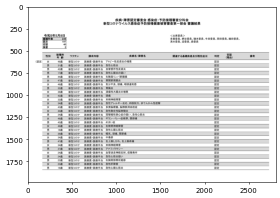

error: ignored

In [ ]:
#PDFを画像変換
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

#データ取得
!wget https://www.mhlw.go.jp/content/10900000/001094635.pdf -O data.pdf
#!wget https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2022/05/31/documents/press0531-20-01.pdf -O data.pdf
#!wget https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2021/12/29/documents/01_00.pdf -O data.pdf
#!wget https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2021/12/24/documents/press1224-20-01.pdf -O data.pdf

#参考：https://qiita.com/shoku-pan/items/7a67f484a10430da6678
#参考2：https://note.com/dngri/n/nbbb83823e8f4
#参考3：https://teratail.com/questions/151317

# PDFファイルのパス
pdf_path = Path("./data.pdf")
#outputのファイルパス
img_path=Path("./")

#この1文で変換されたpngファイルが、imageホルダー内に作られます。
convert_from_path(
    pdf_path,
    output_folder=img_path,
    fmt='png',
    single_file=True,
    output_file=pdf_path.stem,
    grayscale=True
    )
#img = Image.open("./data.png")

# 読み取る文字列が書かれている部分を切り出す
#img_crop = img.crop((100, 100, 1800, 2000))

img_crop = cv2.imread("./data.png")
#img1 = img_crop[950 : 1315, 1500: 2280]
img1 = cv2.resize(img_crop, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)

cv2.imwrite("data1.png", img1)

plt.figure(dpi=50)
plt.imshow(cv2.cvtColor(img1, img1.ndim == 2 and cv2.COLOR_GRAY2RGBA or [cv2.COLOR_BGR2RGBA, cv2.COLOR_BGRA2RGBA][img1.shape[2] - 3]))
plt.show()



#エッジを検出し、必要箇所のアドレスを得る
img00 = cv2.imread('out_test.png')
# BGR -> グレースケール
gray = cv2.cvtColor(img00, cv2.COLOR_BGR2GRAY)
# エッジ抽出 (Canny)
edges = cv2.Canny(gray, 1, 100, apertureSize=3)
cv2.imwrite('edges.png', edges)
# 膨張処理
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges = cv2.dilate(edges, kernel)
# 輪郭抽出

#_, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#OpenCV3では返り値が[image, contours, hierarchy]の3つとなっている
#しかしCV2,CV4では[contours, hierarchy]の2つになっている、このためCV2,CV4では返り値3つにするとエラーが発生するため注意

contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 面積でフィルタリング
rects = []
for cnt, hrchy in zip(contours, hierarchy[0]):
    if cv2.contourArea(cnt) < 3000:
        continue  # 面積が小さいものは除く
    if hrchy[3] == -1:
       continue  # ルートノードは除く
    # 輪郭を囲む長方形を計算する。
    rect = cv2.minAreaRect(cnt)
    rect_points = cv2.boxPoints(rect).astype(int)

    #rect_points時点でソートしておく
    #ベクトルは通常と異なり[x,y]となるため注意
    #四角になるようにしたい
    sort_df = pd.DataFrame(rect_points)
    sort_df = sort_df.sort_values([0])
    if sort_df.iat[1,1] != sort_df.iat[2,1]:
      sort_df = sort_df.reindex([3,0,1,2],axis=0).reset_index(drop=True)
    sort_df = sort_df.reindex([1,0,3,2],axis=0).reset_index(drop=True)

    print(sort_df)
    rect_points = sort_df.to_numpy()
    print(rect_points)
    rects.insert(0,rect_points)



# x-y 順でソート
#YとXが原点に近い順にソートしたい

#rects = sorted(rects, key=lambda x: (x[0][0], x[0][0]))

# 描画する。
for i, rect in enumerate(rects):
    color = np.random.randint(0, 255, 3).tolist()
    cv2.drawContours(img00, rects, i, color, 2)
    cv2.putText(img00, str(i), tuple(rect[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)

    print('rect:\n', rect)

cv2.imwrite('img.png', img00)



#今までの方法
img_crop1 = cv2.imread("./data1.png")
sesshu = np.array(range(4))

add_array = []
print(add_array)

#rectsのアドレスは[x,y]
for k, rectk in enumerate(rects):

  if k>4:
    add = rects[k]
    add_adrs = [add[0,1]+5 , add[2,1]-5 , add[0,0]+5 , add[2,0]-5]
    add_array.append(add_adrs)

add_array = pd.DataFrame(add_array)
print(add_array)

top,bottom,left,right = [add_array.iloc[:,0].min(),add_array.iloc[:,1].max(),add_array.iloc[:,2].min(),add_array.iloc[:,3].max()]

img2 = img_crop1[top : bottom, left: right]
cv2.imwrite("data_small.png", img2)

img1 = Image.open("./data_small.png")

# 文字列を読み取る
tools = pyocr.get_available_tools()
tool = tools[0]

#builder通常版、OCRしたテキストを表記する
builder = pyocr.builders.TextBuilder(tesseract_layout=6)

results = tool.image_to_string(
      img1,
      builder=builder,
      lang="jpn"
      )

print(results)

text=results.replace(' ','')
text=text.replace('.','')
text=text.replace(',','')

text=text.replace('|',',')

print(text)

#pprint.pprint(text)

#print(sesshu)

#builderを位置情報等を格納したboxとして記述する場合
builder_box = pyocr.builders.WordBoxBuilder(tesseract_layout=6)

results_box = tool.image_to_string(
    img1,
    builder=builder_box,
    lang="jpn"
    )


# ファイル名を変更する
#file_name = result + '.pdf'
#os.rename(file, file_name)

draw_rectangle = cv2.imread('./data_small.png')

for box in results_box:
    cv2.rectangle(draw_rectangle, box.position[0], box.position[1], (0, 255, 0), 1)
cv2.imwrite('draw_rectangle.png', draw_rectangle)
draw_rectangle = Image.open('draw_rectangle.png')
draw_rectangle
